In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gamspec
from copy import deepcopy

In [2]:
# 用于寻峰的分支
sav = gamspec.SavitzkySmoother(3, 3)
convol = gamspec.SecondConvolutionPeakSearcher(10)
def dbg(sepctrum):
    sepctrum.regions[0].peaks.append({'location':75})
convol.__dbg__ = dbg
# peakfilter = gamspec.PeakSearcher()
fpeak = gamspec.Flow(gamspec.Pipe([sav, convol]), 0, 0, 1, 0)

# 用于平滑的分支
wavelet = gamspec.TranslationInvarianceWaveletSmoother('dmey', 'quadratic-soft', order=3)
# wavelet = gamspec.SavitzkySmoother(3, 4)
fsmooth = gamspec.Flow(wavelet, 0, 0, 1, 1) 

# 两个分支合并
def combine(spec1, spec2):
    spec2.regions = deepcopy(spec1.regions)
    return spec2
comb = gamspec.Combinor(2, func=combine)
fcomb = gamspec.Flow(comb, 1, [0, 1], 2, 0)

# 剥谱
strp = gamspec.OtherOperator.AdaptiveSNIPStripper(baseline=False)
fstrip = gamspec.Flow(strp, 2, 0, 3, 0)

# 拟合，计算峰面积
fit = gamspec.RegionPeakFitter(10, equal_width=False, baseline=False)
ffit = gamspec.Flow(fit, 3, 0, 4, 0)

pipenet = gamspec.PipeNet([fpeak, fsmooth, fcomb, fstrip, ffit])

In [3]:
file = r'E:\Gamut_dev\spectrum_analysis\模拟Eu152能谱分析\Eu152_benchmark_60000.out'
spectrum = gamspec.Spectrum.from_MCNP(file)
spec = spectrum[:1000]

In [4]:
gamspec.Calibration('linear', [[1, 2], [1, 2]])

d:\Conda\envs\gamut\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
e:\Gamut_dev\gamspec\PeakRegion.py:114: RuntimeWarning: invalid value encountered in scalar divide
  fitness = 1 - ((fitted - self._data[:, 1])**2).sum() / ((data[:, 1] - data[:, 1].mean())**2).sum()


In [5]:
spectrum.ergcal._fitparams(spectrum.ergcal.data)

(array([2.32666708e-05, 2.93176650e-01]), 0.9999999989820945)

In [6]:
# 用于寻峰的分支
sav = gamspec.SavitzkySmoother(3, 3)
convol = gamspec.SecondConvolutionPeakSearcher()
# peakfilter = gamspec.PeakSearcher()
fpeak = gamspec.Flow(gamspec.Pipe([sav, convol]), 0, 0, 1, 0)

# 用于平滑的分支
wavelet = gamspec.TranslationInvarianceWaveletSmoother('dmey', 'quadratic-soft', order=3)
# wavelet = gamspec.SavitzkySmoother(3, 4)
fsmooth = gamspec.Flow(wavelet, 0, 0, 1, 1)

# 两个分支合并
def combine(spec1, spec2):
    spec2.regions = deepcopy(spec1.regions)
    return spec2
comb = gamspec.Combinor(2, func=combine)
fcomb = gamspec.Flow(comb, 1, [0, 1], 2, 0)

# 剥谱
strp = gamspec.OtherOperator.AdaptiveSNIPStripper(baseline=False)
fstrip = gamspec.Flow(strp, 2, 0, 5, 1)

# 重新寻峰
searcher = gamspec.CovarianceSearcher(10, 4, 'inverse')
searcher._min_height_ratio = 0.6
fsearch = gamspec.Flow(searcher, 2, 0, 5, 0)

# 分支合并
comb2 = gamspec.Combinor(2, func=combine)
fcomb2 = gamspec.Flow(comb2, 5, [0, 1], 3, 0)

# 拟合，计算峰面积
fit = gamspec.RegionPeakFitter(3, equal_width=False, baseline=False)
ffit = gamspec.Flow(fit, 3, 0, 4, 0)

pipenet = gamspec.PipeNet([fpeak, fsmooth, fcomb, fstrip, fsearch, fcomb2, ffit])
pipenet([spec])

GAMUT: Start running PipeNet
|Execute: Node 0|[0] >> Pipe >> Node 1|[0]
|Execute: Node 0|[0] >> TIWaveletSmoother[O3MqTv] >> Node 1|[1]
|Execute: Node 1|[0, 1] >> Combinor >> Node 2|[0]
|Execute: Node 2|[0] >> AdaptiveSNIPStripper >> Node 5|[1]
|Execute: Node 2|[0] >> CovarianceSearcher[F4] >> Node 5|[0]


e:\Gamut_dev\gamspec\operators\PeakSearcher.py:263: RuntimeWarning: divide by zero encountered in divide
  weight = 1 / windowed_spectrum
e:\Gamut_dev\gamspec\operators\PeakSearcher.py:270: RuntimeWarning: invalid value encountered in scalar subtract
  variance = sum(weight)*sum(weight*shape**2) - sum(weight*shape)**2
e:\Gamut_dev\gamspec\operators\PeakSearcher.py:272: RuntimeWarning: invalid value encountered in multiply
  covariance = sum(weight)*sum(weight*shape*windowed_spectrum) - sum(weight*windowed_spectrum)*sum(weight*shape)


|Execute: Node 5|[0, 1] >> Combinor >> Node 3|[0]
|Execute: Node 3|[0] >> RegionPeakFitter >> Node 4|[0]
Fitting Region: 77~141, NPeaks=4, time=Wed Jan 24 22:07:06 2024
LinAlgError: partial_matrix.T @ partial_matrix is not invertible.
Use pseudo-inverse instead
Finish Fitting Region: time=Wed Jan 24 22:07:08 2024
Fitting Region: 152~158, NPeaks=1, time=Wed Jan 24 22:07:08 2024
Finish Fitting Region: time=Wed Jan 24 22:07:08 2024
Fitting Region: 409~419, NPeaks=2, time=Wed Jan 24 22:07:08 2024
LinAlgError: partial_matrix.T @ partial_matrix is not invertible.
Use pseudo-inverse instead
Finish Fitting Region: time=Wed Jan 24 22:07:08 2024
Fitting Region: 826~845, NPeaks=1, time=Wed Jan 24 22:07:08 2024
Finish Fitting Region: time=Wed Jan 24 22:07:09 2024


In [7]:
pipenet.get_node(1)[0].ergcal.params

array([2.32666708e-05, 2.93176650e-01])

In [8]:
df = pipenet.get_node(4)[0].export_to_pandas()
# df = df[df['fitness'] > 0.9]
df

,left,right,energy,location,height,stderr,area,sig_area2,fitness
0,77,141,31.076748,106,172.280248,1.081716,467.131126,22.384965,0.953805
1,77,141,35.181221,120,63.617753,0.715388,114.080166,10.614611,0.953805
2,77,141,40.165224,137,68.850828,1.458097,251.643369,33.876806,0.953805
3,152,158,45.442404,155,24.614909,0.774714,47.800163,7.803629,0.900922
4,409,419,121.961510,416,1192.364348,0.608310,1818.126422,43.032539,0.999836
5,826,845,244.802526,835,241.716282,1.634861,990.550873,34.391748,0.999716


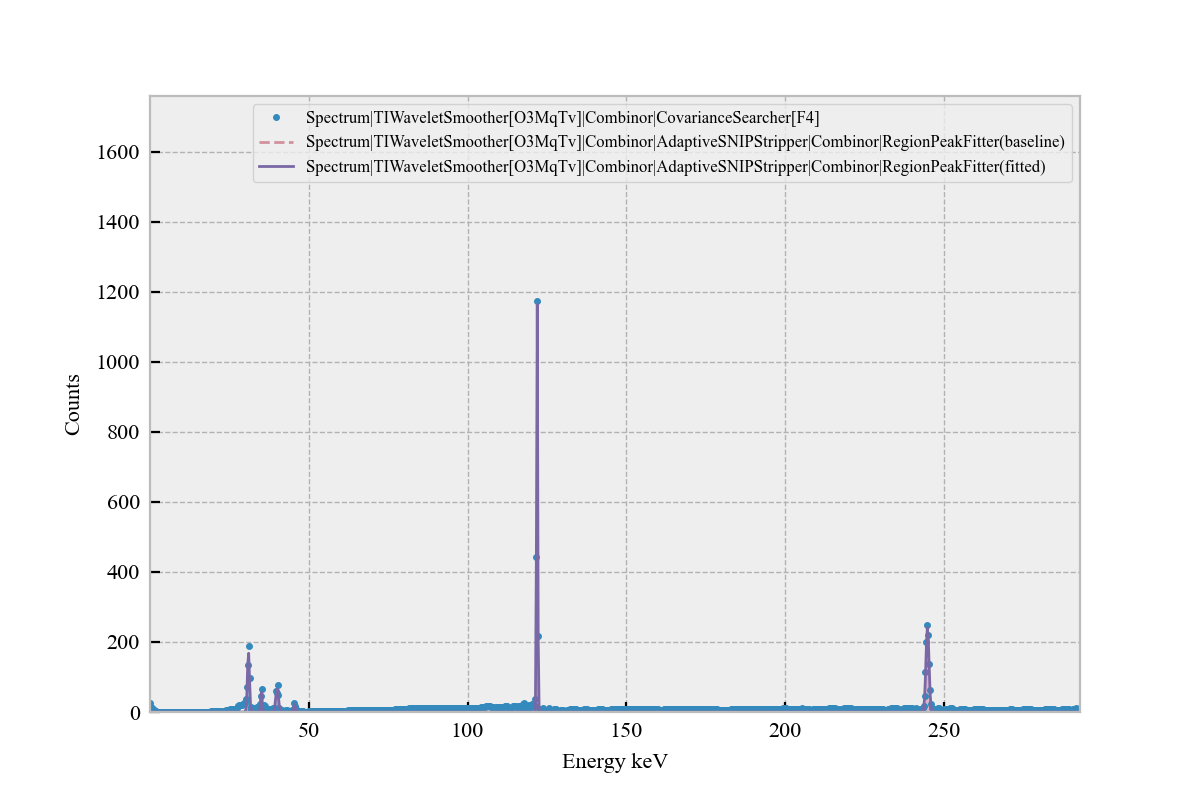

In [9]:
%matplotlib widget
plt.close()
pipenet.get_node(5)[0].plot('.')
# pipenet.get_node(5)[0].plot_regions()
pipenet.get_node(4)[0].plot_peaks()
plt.legend(fontsize=6)
plt.xlabel('Energy keV')
plt.ylabel('Counts')
plt.show()

In [10]:
searcher = gamspec.CovarianceSearcher(10, 6, 'inverse')
searcher._min_area = 100
searcher._min_height = spectrum.mean()
# spec = searcher(spectrum)

# spec.plot()
# spec.plot_regions()

In [11]:
out.plot()
out.plot_peaks()

NameError: name 'out' is not defined